<a href="https://colab.research.google.com/github/jonathanmendoza-tx/DS-Unit-2-Applied-Modeling/blob/master/Jonathan_Mendoza_DS_Sprint_Challenge_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍔

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [1]:
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

     |████████████████████████████████| 102kB 2.7MB/s 
     |████████████████████████████████| 112kB 2.8MB/s 
     |████████████████████████████████| 133kB 2.8MB/s 
     |████████████████████████████████| 614kB 37.6MB/s 
     |████████████████████████████████| 235kB 43.3MB/s 
     |████████████████████████████████| 307kB 47.7MB/s 
     |████████████████████████████████| 215kB 45.2MB/s 
     |████████████████████████████████| 51kB 21.3MB/s 
     |████████████████████████████████| 737kB 39.8MB/s 
     |████████████████████████████████| 51kB 15.2MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145035 sha256=58ec39e31a34b049603426580afaa116452215c8602c9053a83bc6d214032422
  Stored in directory: /root/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27084 sha256=ac4f53ca98fd55dd8a87f01d452d2f48fa2175ec2580ade9793cf45345c0672a
  Stored 

#### Run this cell to load the data:

In [0]:
## Imports
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas_profiling
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import numpy as np
import datetime
from sklearn.cluster import KMeans
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import eli5
from eli5.sklearn import PermutationImportance
import shap
from pdpbox.pdp import pdp_isolate, pdp_plot

In [0]:
train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make all four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [0]:
train, val = train_test_split(train, train_size=0.8, test_size = 0.2,
                              stratify = train['Fail'])

train.shape,val.shape,test.shape

((41532, 17), (10384, 17), (17306, 17))

In [9]:
train.head()

Inspection ID  ... Fail
16097        2159485  ...    0
43007        1335825  ...    0
36706        2059810  ...    0
24613        1937721  ...    0
4005         1372313  ...    1

[5 rows x 17 columns]

In [4]:
train.isna().sum()

Inspection ID         0
DBA Name              0
AKA Name            623
License #             5
Facility Type       224
Risk                 12
Address               0
City                 53
State                10
Zip                  26
Inspection Date       0
Inspection Type       1
Violations         9655
Latitude            198
Longitude           198
Location            198
Fail                  0
dtype: int64

In [10]:
train.profile_report()

/usr/local/lib/python3.6/dist-packages/pandas_profiling/model/correlations.py:124: UserWarning: There was an attempt to calculate the cramers correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"cramers": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/pandas-profiling/pandas-profiling/issues
(include the error message: 'The internally computed table of expected frequencies has a zero element at (0, 19).')
  correlation_name=correlation_name, error=error


Things I took away from profiling:

Datetime format should be applied to inspection date, facility type cardinality should be reduced, violations may have too many NaN's to be useful. 

Also, Violations may leak info from the future into our dataset, because the violations would directly correlate to passing or failing an inspection. 

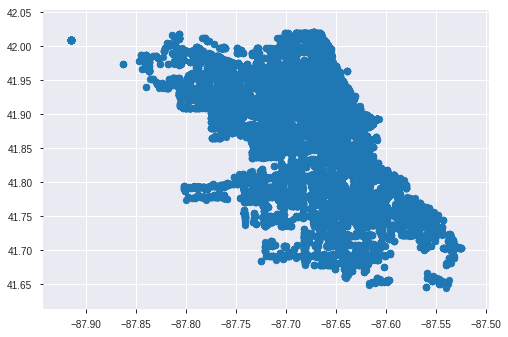

In [132]:
plt.scatter(train['Longitude'], train['Latitude'])

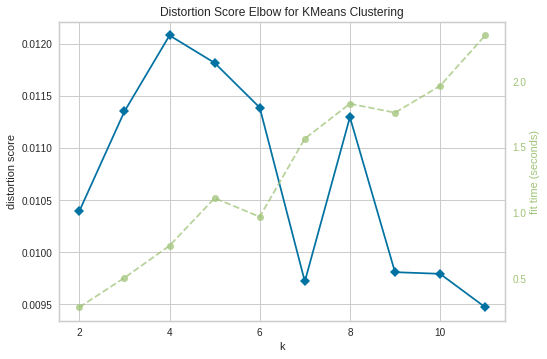

In [138]:
# Did this outside of wrangle to explore, Shows optimal number of clusters equals 7

# train['Latitude'] = train['Latitude'].fillna(method = 'ffill')
# train['Longitude'] = train['Longitude'].fillna(method = 'ffill')

# model = KMeans()
# visualizer = KElbowVisualizer(model, k=(2,12), locate_elbow = True)

# visualizer.fit(train[['Longitude','Latitude']])        # Fit the data to the visualizer
# visualizer.poof()        # Draw/show/poof the data

In [0]:
def wrangle(df):
  """ Reduce cardinality of facility types by recoding. 
      Cluster latitude and longitude, # of clusters (7) based on kmeans elbow graph.
      Inspection date to datetime format.""""

  df['Facility Type'] = df['Facility Type'].str.lower()
  df['Facility_recode'] = np.where(df['Facility Type'].str.contains('day'),'daycare',
                                             np.where(df['Facility Type'].str.contains('school'), 'school',
                                                      np.where(df['Facility Type'].str.contains('shared'), 'shared kitchen',
                                                               np.where(df['Facility Type'].str.contains('mobile'),'mobile food',
                                                                        np.where(df['Facility Type'].str.contains('kiosk'),'kiosk',
                                                                                 np.where(df['Facility Type'].str.contains('church'), 'church',
                                                                                          np.where(df['Facility Type'].str.contains('grocery'), 'grocery',
                                                                                                   np.where(df['Facility Type'].str.contains('gas'),'gas station',
                                                                                                            np.where(df['Facility Type'].str.contains('conveni'), 'convenience', 
                                                                                                                     np.where(df['Facility Type'].str.contains('banquet'), 'banquet',
                                                                                                                              np.where(df['Facility Type'].str.contains('store'), 'store',
                                                                                                                                       np.where(df['Facility Type'].str.contains('shop'), 'shop',
                                                                                                                                                df['Facility Type']
                                                                                                                                                ))))))))))))
  top25 = df['Facility_recode'].value_counts()[:25].index
  df['Facility_recode'] = np.where(df['Facility_recode'].isin(top25),df['Facility_recode'], 'Other' )

  df['Inspection Date'] = pd.to_datetime(df['Inspection Date'],infer_datetime_format=True)
  
  df['Latitude'] = df['Latitude'].fillna(method = 'ffill')
  df['Longitude'] = df['Longitude'].fillna(method = 'ffill')

  model = KMeans(n_clusters = 7, n_jobs = -1 )

  df['Location_cluster'] = model.fit_predict(df[['Latitude','Longitude']])

  return df

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
target = 'Fail'

train_features = train.drop(columns=[target,'City','State']) # we can drop city and state because it is assume to be chicago and its suburbs and the state of Illinois

numeric = train_features.select_dtypes(include = 'number').columns.tolist()

cardinality = train_features.select_dtypes(exclude='number').nunique()

categorical = cardinality[cardinality<=50].index.tolist()

features = numeric + categorical

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [79]:
train['Fail'].value_counts(normalize = True)

0    0.74138
1    0.25862
Name: Fail, dtype: float64

Baseline score of 74.14% with majority class of passing inspection

In [141]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Risk', 'Inspection Type',
                                      'Facility_recode'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Risk',
                                          'data_type': dtype('O'),
                                          'mapping': Risk 1 (High)      1
Risk 2 (Medium)    2
Risk 3 (Low)       3
NaN                4
dtype: int64},
                                         {'col': 'Inspection Type',
                                          'data_type': dtype('O'),
                                          'mapping': Canvas...
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                    

In [142]:
print(f'Validation Accuracy: {pipeline.score(X_val, y_val)}')

y_val_pred_proba = pipeline.predict_proba(X_val)[:, 1]
print(f'Validation ROC AUC score: {roc_auc_score(y_val, y_val_pred_proba)}')

print(f'Test Accuracy: {pipeline.score(X_test, y_test)}')

y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
print(f'Test ROC AUC score: {roc_auc_score(y_test, y_pred_proba)}')

Validation Accuracy: 0.7577041602465331
Validation ROC AUC score: 0.7254915690760584
Test Accuracy: 0.7530914133826418
Test ROC AUC score: 0.6995954891022049


## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

### Eli5 Permutation importances

In [143]:
transformer = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean')
)

X_train_transformed = transformer.fit_transform(X_train)
X_val_transformed = transformer.fit_transform(X_val)

model = RandomForestClassifier(n_jobs=-1, n_estimators= 100)
model.fit(X_train_transformed, y_train)

permuter = PermutationImportance(
    model,
    scoring = 'accuracy',
    n_iter = 2,
    random_state = 42
)

permuter.fit(X_val_transformed, y_val)
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter,
    top = None,
    feature_names = feature_names
)

Inpection type and inspection ID truly have a high importance when determining the target

### Shapley values

In [181]:
row = X_test.iloc[[0]]

explainer = shap.TreeExplainer(pipeline.steps[2][1])

row_process = transformer.transform(row)
shap_values = explainer.shap_values(row_process)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0],
    shap_values=shap_values[0],
    features=row)

In [179]:
row = X_test.iloc[[10]]

explainer = shap.TreeExplainer(pipeline.steps[2][1])

row_process = transformer.transform(row)
shap_values = explainer.shap_values(row_process)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0],
    shap_values=shap_values[0],
    features=row)

Here we see the overall effects of each variable on the target equalling 0 for two individual businesses

In [199]:
y_pred = pipeline.predict(X_test)
y_val_lis = y_val.to_list()

print(f'Predictions for each of those businesses \n{y_pred[0]}\n{y_pred[10]}')
print(f'Actual value for each of those businesses \n{y_val_lis[0]}\n{y_val_lis[10]}')

Predictions for each of those businesses 
0
0
Actual value for each of those businesses 
0
1


Both businesses are predicted to pass inspection, as expected from the higher than baseline, but the prediction fails for the 2nd business that was tested.

### Partial dependence plot, with location cluster

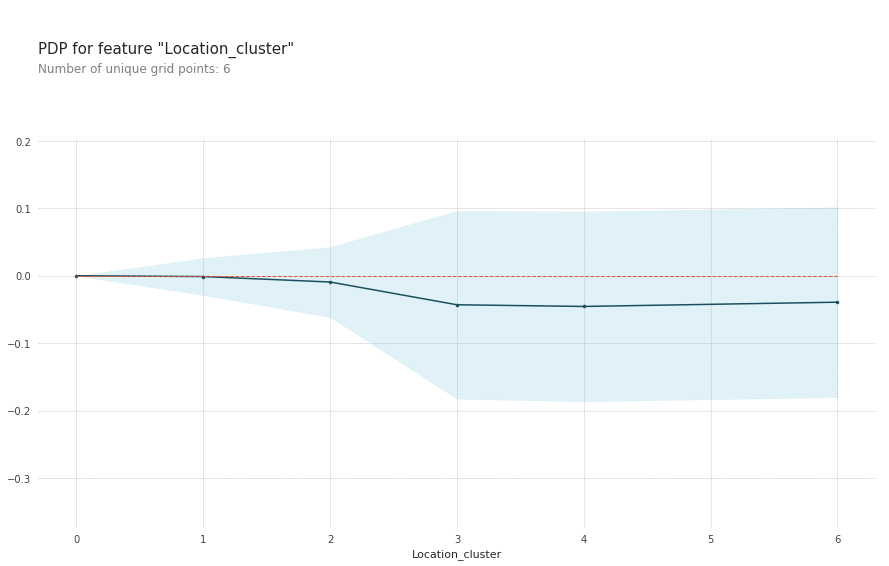

In [166]:
feature = 'Location_cluster'

isolated = pdp_isolate(
    model = pipeline,
    dataset = X_val,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

Location clusters are neutral on average at cluster 0 and 1, but above one starts to have an average negative effect on the determination of the target.